try MCX simulation with 0.1mm resolution

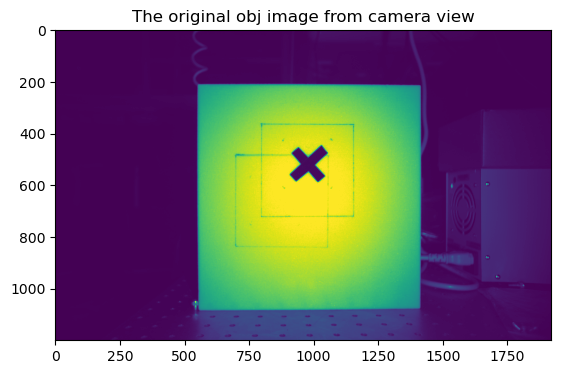

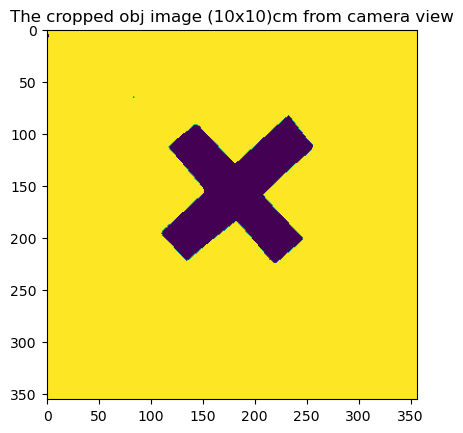

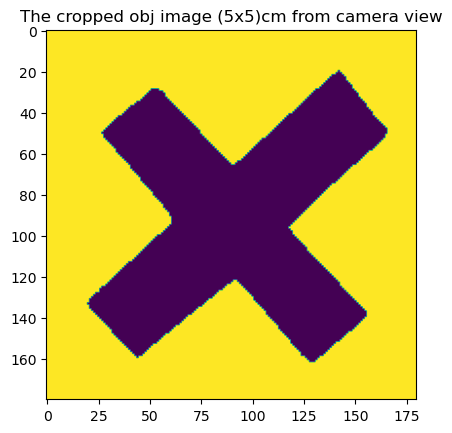

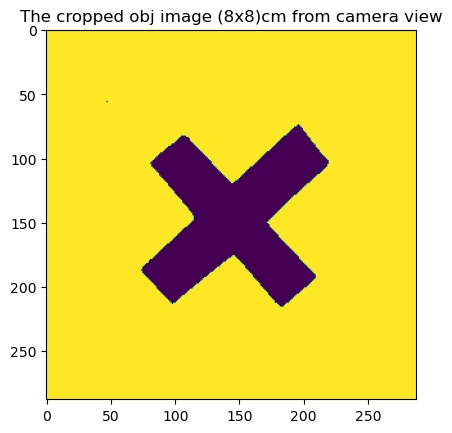

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pmcx
from cv2 import resize
import cv2
import os
from tqdm import tqdm
from scipy.signal import fftconvolve
pmcx.__version__   # print imported pmcx version number

mcx_unitinmm = 0.5  # define the mcx unit in mm
foam_size = 126


#%% read and process obj image, note the obj image is capture from the galvo view
data_fold = 'F:/OneDrive/UK_projects_local/project in UK 2024/diffuse_experiment241021/zhiguan_data/XL_measurement_061224'
obj_img_path = os.path.join(data_fold, 'X_061224.bmp')
obj_img = plt.imread(obj_img_path)

#---------------get the obj ROI defined by the nine holes-----------
obj_img_10x10 = obj_img[363:719, 799:1156]
obj_img_10x10 = obj_img_10x10/obj_img_10x10.max()
obj_img_10x10[obj_img_10x10<0.5] = 0   # keep the obj as zero, a photon is terminated when moving from a non-zero to zero voxel.
obj_img_10x10[obj_img_10x10>=0.5] = 1

#---------------find the centre from the top, bottom and side of the image edges (10x10)cm----------
pix_ratio = np.round(np.mean([obj_img_10x10.shape[0], obj_img_10x10.shape[1]])/10)
from_top = np.round((1.75 + 2.5)*pix_ratio).astype('int') # center pixel to top edge in obj_img_10x10 measured in pixel scale
from_bot = np.round((10 - 1.75 - 2.5)*pix_ratio).astype('int') # center pixel to bottom edge in obj_img_10x10 measured in pixel scale
from_side = np.round(5*pix_ratio).astype('int') # center pixel to side edge in obj_img_10x10 measured in pixel scale
pix_4cm = np.round(4*pix_ratio).astype('int') # choose border 4cm from centre for a FOV=(8x8)cm
pix_2dot5cm = np.round(2.5*pix_ratio).astype('int') # choose border 4cm from centre for a FOV=(8x8)cm

#---------------crop required size--------------
obj_img_5x5 = obj_img_10x10[from_top - pix_2dot5cm:from_top + pix_2dot5cm,
                            from_side -pix_2dot5cm:from_side + pix_2dot5cm]

obj_img_8x8 = obj_img_10x10[from_top - pix_4cm:from_top + pix_4cm,
                            from_side -pix_4cm:from_side + pix_4cm]

#-------------------show the obj img-------------------
plt.figure()
plt.imshow(obj_img)
plt.title('The original obj image from camera view')
plt.show()

plt.figure()
plt.imshow(obj_img_10x10)
plt.title('The cropped obj image (10x10)cm from camera view')
plt.show()

plt.figure()
plt.imshow(obj_img_5x5)
plt.title('The cropped obj image (5x5)cm from camera view')
plt.show()

plt.figure()
plt.imshow(obj_img_8x8)
plt.title('The cropped obj image (8x8)cm from camera view')
plt.show()

sensitivity map

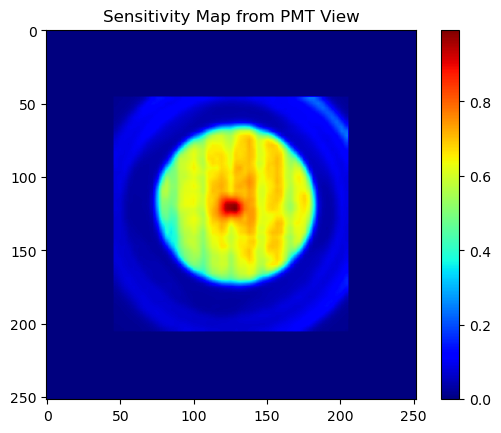

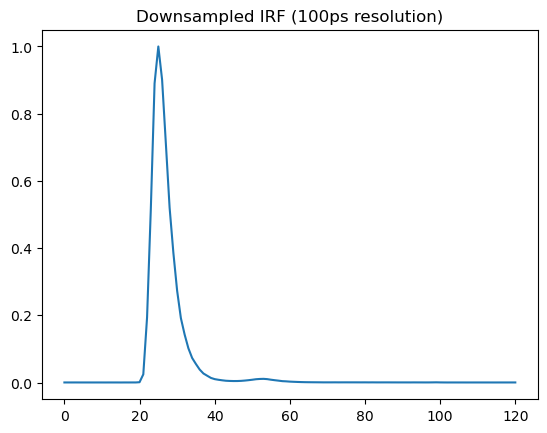

In [20]:
#-----------------prepare the sensitibity map-------------
sems_path = os.path.join(data_fold,r'sensitivity_map_gain0.7_8x8cm_51x51points_binWidth15ps_expo0.1sec_binNum2000_40deg_061224.npy')
sensitivity = np.load(sems_path).sum(2)

sensitivity = sensitivity/sensitivity.max()                                 # normalize the sensitivity map 
sensitivity = np.fliplr(sensitivity)                                        # flip to make sure the sensitivity map is from PMT view
sensitivity = resize(sensitivity, (int(np.round(80/mcx_unitinmm)),int(np.round(80/mcx_unitinmm))), interpolation=cv2.INTER_LINEAR)  # resize to (80,80) to match the (8x8)cm FOV

sens_padding = int((foam_size-80)/2/mcx_unitinmm)  # add padding to make sure the photons won't escape from the volume sides

sens_pad = cv2.copyMakeBorder(
    sensitivity, 
    sens_padding, sens_padding, sens_padding, sens_padding,                 # the padding range form four sides
    cv2.BORDER_CONSTANT, 
    value=0
    )

plt.figure()
plt.imshow(sens_pad,'jet')
plt.title('Sensitivity Map from PMT View')
plt.colorbar()
plt.show()

#-----------------prepare the IRF---------------------
IRF_path = os.path.join(data_fold,r'IRF_gain0.7_timebin15ps_2000bins_061224.npy')
IRF = np.load(IRF_path)[:1000]
IRF_down = resize(IRF[:np.round(121*100/15).astype('int')], (1, 121), interpolation=cv2.INTER_NEAREST_EXACT)
IRF_down= np.squeeze(IRF_down)
IRF_down = IRF_down/IRF_down.max()      # normalize the IRF
plt.figure()
plt.plot(IRF_down)
plt.title('Downsampled IRF (100ps resolution)')
plt.show()


76


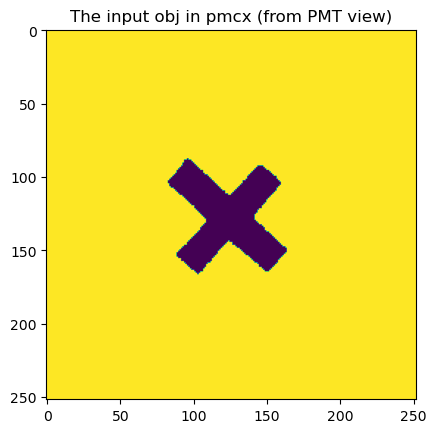

In [17]:
#--------------note the MCX output is from the PMT view-------------
obj_in_mcx = cv2.resize(obj_img_5x5, (int(np.round(50/mcx_unitinmm)),int(np.round(50/mcx_unitinmm))), interpolation=cv2.INTER_NEAREST)
obj_in_mcx_PMT = np.flip(obj_in_mcx,1)  # flip the obj to make sure that the obj is form the PMT view

padding_pixels = np.round((foam_size-50)/2/mcx_unitinmm).astype('int')  # add padding to make sure the photons won't escape from the volume sides
print(padding_pixels)
obj_in_mcx_PMT_padding = cv2.copyMakeBorder(
    obj_in_mcx_PMT, 
    padding_pixels, padding_pixels, padding_pixels, padding_pixels,                 # the padding range form four sides
    cv2.BORDER_CONSTANT, 
    value=1                             # the padding value
)

obj_in_mcx_PMT_padding = np.uint8(obj_in_mcx_PMT_padding)

# %matplotlib inline
plt.figure()
plt.imshow(obj_in_mcx_PMT_padding)
plt.title('The input obj in pmcx (from PMT view)')
plt.show()

#==========================creating the MCX volume=====================
thickness = 50 # mm
t_vox = int(thickness/mcx_unitinmm)
vol = np.ones([int(np.round(foam_size/mcx_unitinmm)),int(np.round(foam_size/mcx_unitinmm)),t_vox+1],dtype='uint8')
vol[:,:,-1] = 0
vol[:,:,int(vol.shape[2]/2)-1] = np.rot90(obj_in_mcx_PMT_padding,k = -1,axes = (0,1)) # rotate the input OBJ in the MCX to make sure shape is correct

#===========================MCX cfg================================
try:
    cfg.clear()
except NameError:
    pass  

cfg = {'nphoton': 1e7, 
       'vol': vol, 
       'tstart':0, 
        'tend':12.1e-9, # 10.1
        'tstep':0.1e-9, # 100 ps resolution
       'unitinmm':mcx_unitinmm,
       # 'detpos': [125, 125, t_vox, 4], #radius approx 1mm (4vox) (fibre ~2mm from sample)
       'issrcfrom0':1,
    #    'issavedet':1,
       'issaveref':1,
    #    'debuglevel':'P'
       }


cfg['prop'] = [[0,0,1,1],           # background
               [0.0019, 1.4800,0,1.44], # volume 1
               ]

# cfg['prop'] = [[0,0,1,1],           # background
#                [0.002269, 1.5900,0,1.44], # volume 1
#                ]


run the mcx sims

In [18]:
# cfg['srcpos'] = [np.round(40/mcx_unitinmm), np.round(40/mcx_unitinmm), 0]
cfg['srcdir'] = [0,0,1]

res = pmcx.run(cfg)

cfg['srcpos'] = np.zeros([1,3])
pmcx_exp_x_3x3 = np.zeros((3,3,121))

src_x_positions = np.linspace(np.round((foam_size/2+25)/mcx_unitinmm).astype(int),np.round((foam_size/2-25)/mcx_unitinmm).astype(int),pmcx_exp_x_3x3.shape[0])          # from PMT view, from right to left
src_y_positions = np.linspace(np.round((foam_size/2+25)/mcx_unitinmm).astype(int),np.round((foam_size/2-25)/mcx_unitinmm).astype(int),pmcx_exp_x_3x3.shape[0])          # from PMT view, from up to down

# ==================scan the laser point=================
# note i is row, which is Y, j is column in numpy array, which in pmcx means X
for i, pos_y in tqdm(enumerate(src_y_positions)):
    for j, pos_x in tqdm(enumerate(src_x_positions)):
        cfg['srcpos'] = [pos_x, pos_y, 0]
        res = pmcx.run(cfg)
        dref_bd = res['dref'][:,:,int(vol.shape[2]-1),:]                    # get the boundary value
        dref_bd_rot = np.rot90(dref_bd, k=1, axes = (0,1))                  # rotate the output to get correct angle
        pmcx_exp_x_3x3[i,j,:] = (dref_bd_rot*sens_pad[:,:,None]).sum((0,1))     # apply the sensitivity map
            
pmcx_exp_x_3x3 = np.apply_along_axis(lambda m: fftconvolve(m, IRF_down, mode='full'), axis=2, arr=pmcx_exp_x_3x3)[:,:,:len(IRF_down)]
pmcx_exp_x_3x3 = pmcx_exp_x_3x3/pmcx_exp_x_3x3.max()


nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 0.5
issaveref: 1


0it [00:00, ?it/s]

nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 0.5
issaveref: 1


nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 0.5
issaveref: 1


nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 0.5
issaveref: 1


3it [00:58, 19.42s/it]
1it [00:58, 58.26s/it]

nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 0.5
issaveref: 1


nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 0.5
issaveref: 1


nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 0.5
issaveref: 1


3it [00:52, 17.51s/it]
2it [01:50, 54.90s/it]

nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 0.5
issaveref: 1


nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 0.5
issaveref: 1


nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 0.5
issaveref: 1


3it [00:56, 18.80s/it]
3it [02:47, 55.75s/it]


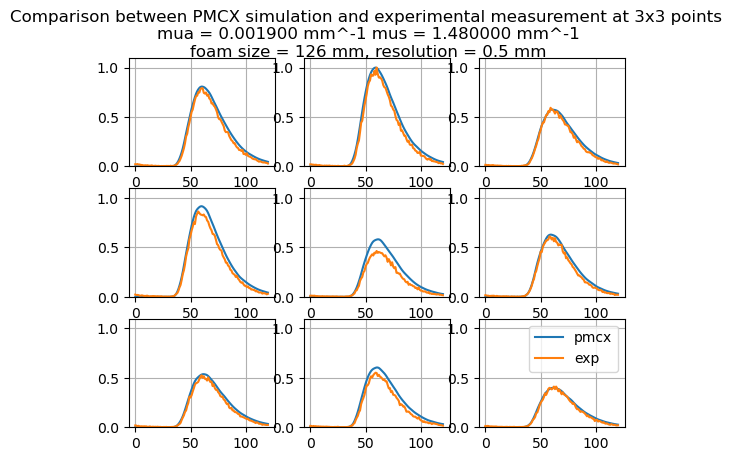

In [19]:

plt.figure()
exp_3x3 = np.load('F:/OneDrive/foam_imaging_project/pmcx_foam/experiment_data/exp_real_X_3x3_data.npy')
for i, index_i in enumerate([0, 15, 30]):
    for j,index_j in enumerate([0, 15, 30]):
        plt.subplot(3,3,3*i+j+1)
        # plt.plot(y[i,j,:], label='data')
        plt.plot(pmcx_exp_x_3x3[i,j,:], label='pmcx')
        plt.plot(exp_3x3[i,j,:], label='exp')
        plt.ylim([0,1.1])
        plt.grid()
plt.legend()

plt.suptitle(
    f"Comparison between PMCX simulation and experimental measurement at 3x3 points \n"
    f"mua = {cfg['prop'][1][0]:.6f} mm^-1 "
    f"mus = {cfg['prop'][1][1]:.6f} mm^-1\n"
    f"foam size = {foam_size} mm, resolution = {mcx_unitinmm} mm"
)

plt.show()

--- 开始单次模拟 ---
Resources loaded. Volume shape: (126, 126), IRF len: 121
Raw data will be saved to: F:\OneDrive\foam_imaging_project\pmcx_foam\experiment_data\MCX_raw_data_output
Running simulation for mua=0.0019, mus=1.48...


  0%|          | 0/3 [00:00<?, ?it/s]

nphoton: 1e+08
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
nphoton: 1e+08
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
nphoton: 1e+08
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1


 33%|███▎      | 1/3 [00:27<00:55, 27.83s/it]

nphoton: 1e+08
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
nphoton: 1e+08
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
nphoton: 1e+08
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1


 67%|██████▋   | 2/3 [00:51<00:25, 25.66s/it]

nphoton: 1e+08
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
nphoton: 1e+08
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
nphoton: 1e+08
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1


100%|██████████| 3/3 [01:18<00:00, 26.16s/it]


Convolving with IRF...


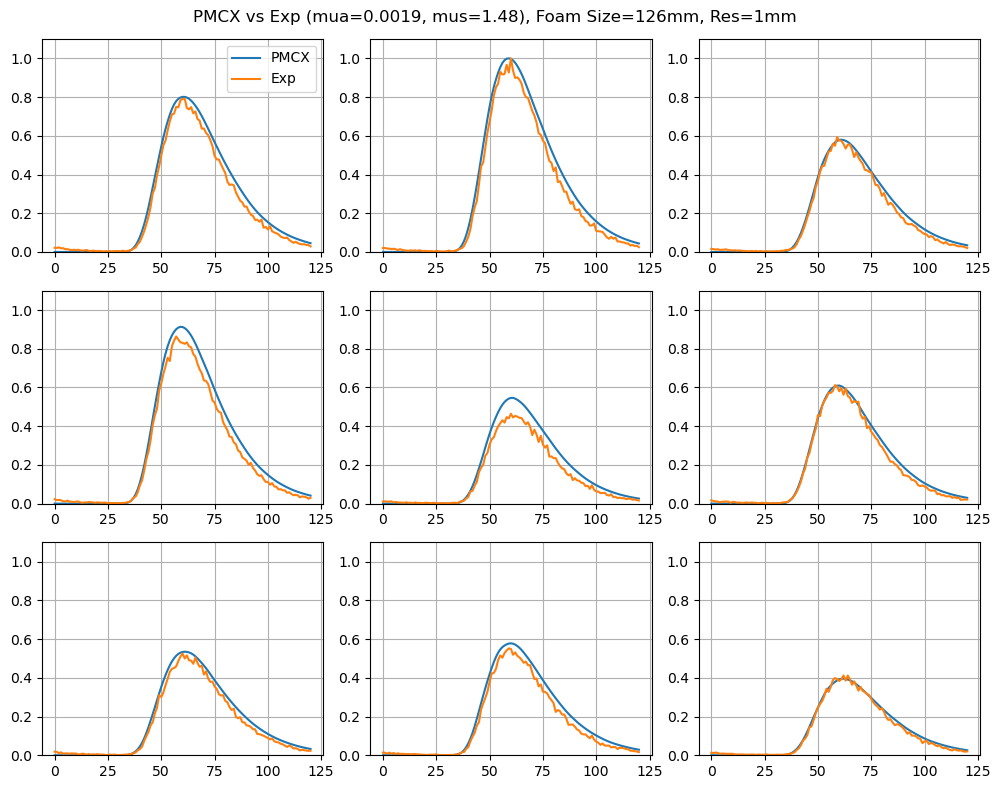

In [4]:
# 文件名: main.py
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('F:/OneDrive/foam_imaging_project/pmcx_foam/pmcx_fitting_sims_py')  # 添加模块路径
# === 关键：从 mcx_utils.py 导入类 ===
from pixelisation_function import MCXFoamSimulator 


# 1. 设置数据路径 (建议使用绝对路径或原始字符串 r'')
data_fold = r'F:/OneDrive/UK_projects_local/project in UK 2024/diffuse_experiment241021/zhiguan_data/XL_measurement_061224'
exp_data_path = r'F:/OneDrive/foam_imaging_project/pmcx_foam/experiment_data/exp_real_X_3x3_data.npy'

# 文件名定义
obj_file = 'X_061224.bmp'
sens_file = 'sensitivity_map_gain0.7_8x8cm_51x51points_binWidth15ps_expo0.1sec_binNum2000_40deg_061224.npy'
irf_file = 'IRF_gain0.7_timebin15ps_2000bins_061224.npy'

"""运行单次模拟的例子"""
print("--- 开始单次模拟 ---")

# 实例化：在这里修改分辨率，例如 unit_mm=0.1
# 注意：0.1mm分辨率会极其消耗显存和时间，建议先用 0.5mm 测试跑通
sim = MCXFoamSimulator(data_fold, unit_mm = 1, foam_size_mm = 126)

# 加载资源
sim.load_and_process_resources(obj_file, sens_file, irf_file)

# 构建体积
sim.build_volume(thickness_mm=50)

# 运行扫描 (设置光学参数)
mu_a = 0.0019
mu_s = 1.48
results = sim.run_grid_scan(mu_a=mu_a, mu_s=mu_s, grid_shape=(3,3), nphoton=1e8,
                            save_raw=True, save_dir='F:/OneDrive/foam_imaging_project/pmcx_foam/experiment_data/MCX_raw_data_output')

# 绘图
sim.plot_comparison(exp_data_path=exp_data_path)



<Figure size 640x480 with 0 Axes>

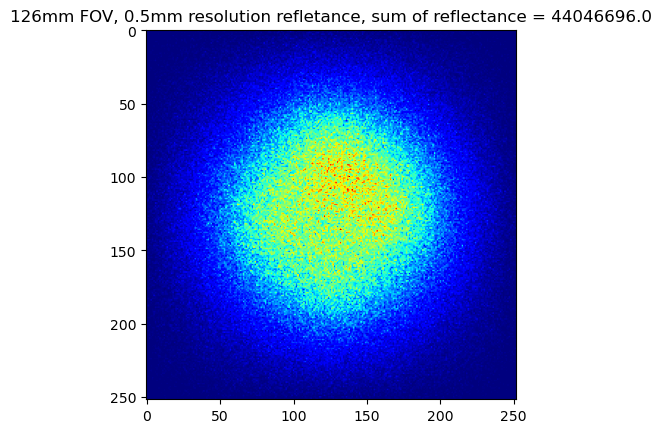

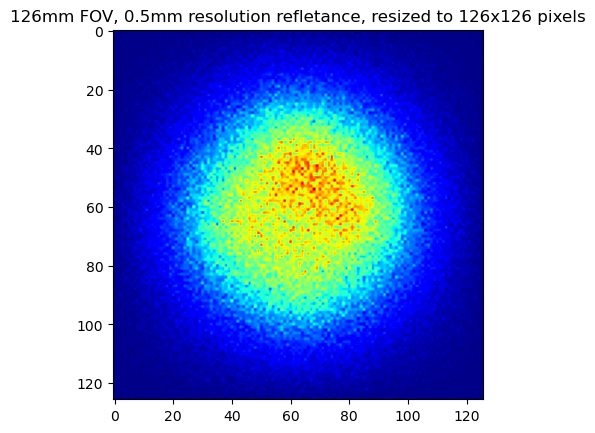

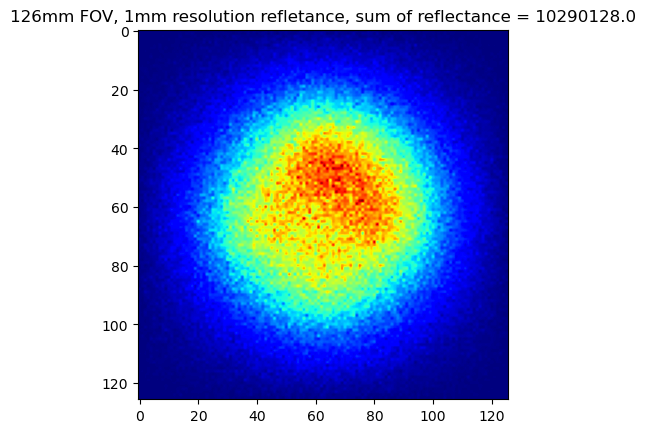

44046696.0
10290128.0


In [24]:
dref_0_5mm = np.load('F:/OneDrive/foam_imaging_project/pmcx_foam/experiment_data/MCX_raw_data_output/dref_row1_col1_mua0.0019_mus1.48_foamsize126_resolution0.5.npy')
dref_1mm = np.load('F:/OneDrive/foam_imaging_project/pmcx_foam/experiment_data/MCX_raw_data_output/dref_row1_col1_mua0.0019_mus1.48_foamsize126_resolution1.npy')
%matplotlib inline
from cv2 import resize
import cv2


plt.figure()
plt.imshow(dref_0_5mm.sum(2), 'jet')
# plt.imshow(resize(dref_0_5mm.sum(2), (dref_1mm.shape[0], dref_1mm.shape[1])), 'jet')
plt.title(f'126mm FOV, 0.5mm resolution refletance, sum of reflectance = {dref_0_5mm.sum()}')
plt.show()


plt.figure()
# plt.imshow(dref_0_5mm.sum(2), 'jet')
plt.imshow(resize(dref_0_5mm.sum(2), (dref_1mm.shape[0], dref_1mm.shape[1]),interpolation = cv2.INTER_CUBIC), 'jet')
plt.title(f'126mm FOV, 0.5mm resolution refletance, resized to 126x126 pixels')
plt.show()

plt.figure()
plt.imshow(dref_1mm.sum(2), 'jet')
plt.title(f'126mm FOV, 1mm resolution refletance, sum of reflectance = {dref_1mm.sum()}')
plt.show()

print(dref_0_5mm.sum())
print(dref_1mm.sum())